<a href="https://colab.research.google.com/github/MariaLavrovskaya/LGD-predictions/blob/main/cat_boost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries if virtualenv installation is not provided 
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install catboost
!pip install shap

# Mounting disk to save model logs 
from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     |████████████████████████████████| 67.4 MB 45 kB/s 
     |████████████████████████████████| 356 kB 4.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491640 sha256=41db6416cd3861f26a934e6d10b9f4ef2196c05a4b5cf96f95223de7ccda2bad
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
Mounted at /content/drive


In [2]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv, metrics

# data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/Dissertation/code/LGD_Data_pass.xlsx')


In [3]:
# Checking allocated gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug 13 08:12:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# exporting the file
from google.colab import files
uploaded = files.upload()

Saving LGD_Data_pass.xlsx to LGD_Data_pass.xlsx


In [5]:
import io
data = pd.read_excel(io.BytesIO(uploaded['LGD_Data_pass.xlsx']))

In [6]:
from time import sleep
pd.set_option('display.max_rows', None)
# data.select_dtypes(include=['int64', 'float64'])
data.isnull().sum() 



ID_loan                     0
Period                      0
Act_endg_upb                0
delq_sts                    0
loan_age                    0
mths_remng                  0
repch_flag                  0
flag_mod                 1056
CD_Zero_BAL                 0
Dt_zero_BAL                 0
New_Int_rt                  0
Amt_Non_Int_Brng_Upb        0
Dt_Lst_Pi                  22
MI_Recoveries               1
Net_Sale_Proceeds           1
Non_MI_Recoveries           1
Expenses                    1
legal_costs                 1
maint_pres_costs            1
taxes_ins_costs             1
misc_costs                  1
actual_loss                19
modcost                     0
stepmod_ind              1056
dpm_ind                  1056
eltv                     1056
zb_removal_upb              0
dlq_acrd_int                0
disaster_area_flag       1056
borr_assist_ind          1055
orig_upb                    0
lag_id_loan                 0
lag_non_int_brng_upb        0
prior_upb 

### Preprocessing stage

In [7]:
# Quick data cleaning, dropping columns for the following reasons : 1) no values or 2) id
data = data.drop(['Act_endg_upb', 'flag_mod', 'stepmod_ind', 'dpm_ind', 'eltv', 'disaster_area_flag', 'borr_assist_ind', 'vintage',
                  'lag_id_loan', 'month_string', 'delq_string'], axis=1)

# Dropping columns that are included in the actual loss calculations
# data = data.drop([])

In [8]:
# 'delq_string'
# Currently this is deleted from the analysis. 


In [8]:
# Treating NaN values
data.isnull().any()
data=data.dropna()

In [9]:
import numpy as np
#Drop all the datetime columns for now
data.columns.to_series().groupby(data.dtypes).groups
# data = data.drop(['Period', 'Dt_zero_BAL', 'Dt_Lst_Pi', 'prior_period', 'orign_qtr', 'dt_first_pi'], axis=1)
# All LGD > 1 we convert to 1
data['LGD'] = np.where(data.LGD > 1, 1, data.LGD)

In [10]:
# data['delq_sts'].loc[data['delq_sts'] == ' ']
# plt.hist(data['LGD'].loc[data['channel'] == 'C'])
pd.unique(data['cnt_borr'])


array([1, 2])

In [12]:
# plt.hist(data['LGD'].loc[data['channel'] == 'R'])
# plt.hist(data['LGD'].loc[data['cnt_borr'] == 1])
clear_output()

NameError: ignored

In [11]:
# Converting years and months
from IPython.display import clear_output
clear_output()
# data['Period'] = pd.to_datetime(data['Period'], format='%Y%m')
# data['Dt_zero_BAL'] = pd.to_datetime(data['Dt_zero_BAL'], format='%Y%m')
# data['Dt_Lst_Pi'] = pd.to_datetime(data['Dt_Lst_Pi'], format='%Y%m')
# data['prior_period'] = pd.to_datetime(data['prior_period'], format='%Y%m')
# data['dt_first_pi'] = pd.to_datetime(data['dt_first_pi'], format='%Y%m')
# Converting quarters 
intr = data['orign_qtr'].str.replace(r'(Q\d)(\d+)', r'\2-\1')
data['orign_qtr'] = pd.PeriodIndex(intr, freq='Q').to_timestamp()


In [12]:
# Separating into X and y
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'Non_MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds'], axis=1)
y = data['LGD']

### Explanatory

In [13]:
import matplotlib as mpl
plt.style.use(['seaborn-white', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})
%matplotlib inline

In [63]:
df_num['Period'].groupby([df_num['Period'].dt.to_period('Y')]).count().to_dict()

{Period('2011', 'A-DEC'): 11,
 Period('2012', 'A-DEC'): 212,
 Period('2013', 'A-DEC'): 290,
 Period('2014', 'A-DEC'): 130,
 Period('2015', 'A-DEC'): 111,
 Period('2016', 'A-DEC'): 65,
 Period('2017', 'A-DEC'): 47,
 Period('2018', 'A-DEC'): 28,
 Period('2019', 'A-DEC'): 13,
 Period('2020', 'A-DEC'): 1}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


AttributeError: ignored

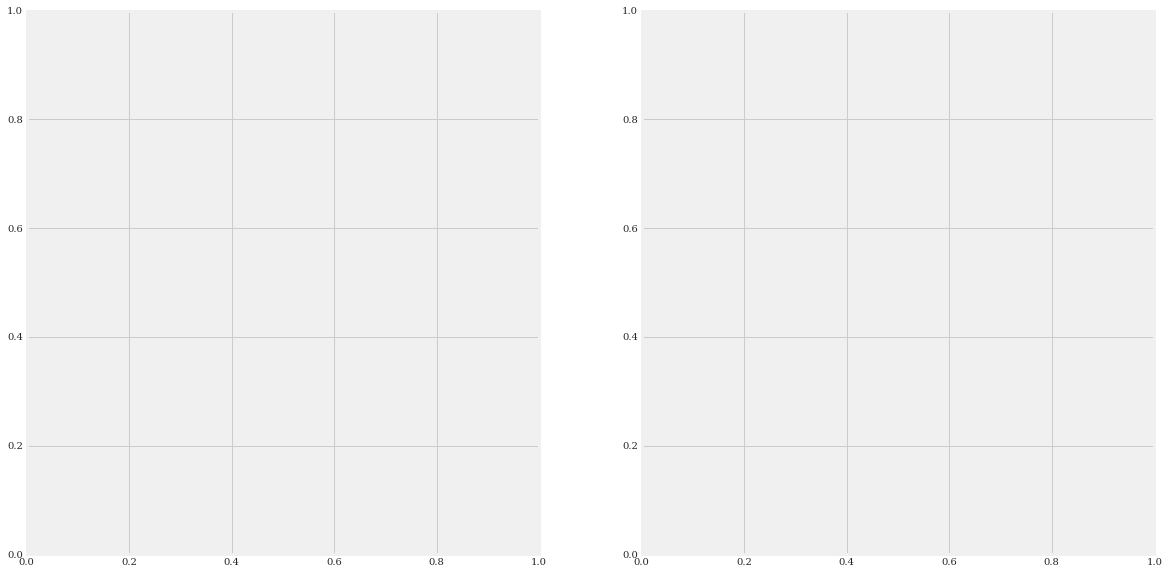

In [58]:
# set aside numerical
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.head()


# Bar plots of the "Period" // The as-of month for loan information contained in the loan record.
fig1, ax1 = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(18, 10))

df_num['Period'] = pd.to_datetime(df_num['Period'], format='%Y%m')
df_num['Period'].groupby([df_num['Period'].dt.to_period('Y')]).count().plot(kind='bar')
data['orign_qtr'].groupby([data['orign_qtr'].dt.to_period('Q')]).count().plot(kind='bar')
# ax[0,0].plot(df_num['Period'].groupby([df_num['Period'].dt.to_period('Y')]).count(), kind='bar') #grouping. by year (Y) or by month (M)




# df_num.drop(['stratification'], axis=1).hist(figsize=(16, 20), bins=60, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [45]:
# calculating lgds for "channel"
lgd_retail = [data['LGD'].loc[(data['channel'] == 'R') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_broker = [data['LGD'].loc[(data['channel'] == 'B') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_correspondent = [data['LGD'].loc[(data['channel'] == 'C') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]


all_lgd = [pd.concat([dataset for dataset in lgd_retail]), pd.concat([dataset for dataset in lgd_broker]), pd.concat([dataset for dataset in lgd_correspondent])]
clear_output()
# loan_purpose
lgd_N = [data['LGD'].loc[(data['loan_purpose'] == 'N') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_C = [data['LGD'].loc[(data['loan_purpose'] == 'C') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_P = [data['LGD'].loc[(data['loan_purpose'] == 'P') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_purpose = [pd.concat([dataset for dataset in lgd_N]), pd.concat([dataset for dataset in lgd_C]), pd.concat([dataset for dataset in lgd_P])]

# property type 
lgd_SF = [data['LGD'].loc[(data['prop_type'] == 'SF') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #single family home
lgd_CO = [data['LGD'].loc[(data['prop_type'] == 'CO') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #condo
lgd_PU = [data['LGD'].loc[(data['prop_type'] == 'PU') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #planned unit development
lgd_MH = [data['LGD'].loc[(data['prop_type'] == 'MH') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #manufactured home
lgd_CP = [data['LGD'].loc[(data['prop_type'] == 'CP') & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins] #cooperative share
all_lgd_PROP_TYPE = [pd.concat([dataset for dataset in lgd_SF]), pd.concat([dataset for dataset in lgd_CO]), pd.concat([dataset for dataset in lgd_PU]), pd.concat([dataset for dataset in lgd_MH]), pd.concat([dataset for dataset in lgd_CP])]

#loan-to-value ratio 
lgd_low = [data['LGD'].loc[(data['ltv'] <= 46) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_middle = [data['LGD'].loc[((data['ltv'] > 46) & (data['ltv'] <= 66)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_high_middle = [data['LGD'].loc[((data['ltv'] > 66) & (data['ltv'] <= 85)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_low_high = [data['LGD'].loc[((data['ltv'] > 86) & (data['ltv'] <= 106)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_high_high = [data['LGD'].loc[((data['ltv'] > 106) & (data['ltv'] <= 125)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_LTV = [pd.concat([dataset for dataset in lgd_low]), pd.concat([dataset for dataset in lgd_middle]), pd.concat([dataset for dataset in lgd_high_middle]), pd.concat([dataset for dataset in lgd_low_high]), pd.concat([dataset for dataset in lgd_high_high])]

#Mortgage insurance percentage (mi_pct):
lgd_mi_pct_low =  [data['LGD'].loc[(data['mi_pct'] <= 10) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_mi_pct_middle = [data['LGD'].loc[((data['mi_pct'] > 10) & (data['mi_pct'] <= 20)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_mi_pct_high_middle = [data['LGD'].loc[((data['mi_pct'] > 20) & (data['mi_pct'] <= 30)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_mi_pct_high = [data['LGD'].loc[((data['mi_pct'] > 30) & (data['mi_pct'] <= 40)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_mi_pct = [pd.concat([dataset for dataset in lgd_mi_pct_low]), pd.concat([dataset for dataset in lgd_mi_pct_middle]), pd.concat([dataset for dataset in lgd_mi_pct_high_middle]), pd.concat([dataset for dataset in lgd_mi_pct_high])]

# Changes in interest rate
rate_unchanged = [data['LGD'].loc[(data['New_Int_rt'] == data['int_rt']) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
rate_changed = [data['LGD'].loc[(data['New_Int_rt'] != data['int_rt']) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_interest_rate = [pd.concat([dataset for dataset in rate_unchanged]), pd.concat([dataset for dataset in rate_changed])]



#UPB at origination date of the mortgage 
lgd_orig_upb_lowest =  [data['LGD'].loc[(data['orig_upb'] <= 100000) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_low_middle = [data['LGD'].loc[((data['orig_upb'] > 100000) & (data['orig_upb'] <= 200000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_high_middle = [data['LGD'].loc[((data['orig_upb'] > 200000) & (data['orig_upb'] <= 300000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_low_high = [data['LGD'].loc[((data['orig_upb'] > 300000) & (data['orig_upb'] <= 400000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_high_high = [data['LGD'].loc[((data['orig_upb'] > 400000) & (data['orig_upb'] <= 500000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
lgd_orig_upb_top = [data['LGD'].loc[((data['orig_upb'] > 500000) & (data['orig_upb'] <= 554000)) & ((data['LGD'] == bin) | ((data['LGD'] > bin) &  (data['LGD'] < bin+ 0.1)))] for bin in bins]
all_lgd_orig_upb = [pd.concat([dataset for dataset in lgd_orig_upb_lowest]), pd.concat([dataset for dataset in lgd_orig_upb_low_middle]), pd.concat([dataset for dataset in lgd_orig_upb_high_middle]), pd.concat([dataset for dataset in lgd_orig_upb_low_high]), pd.concat([dataset for dataset in lgd_orig_upb_high_high]), pd.concat([dataset for dataset in lgd_orig_upb_top])]






/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


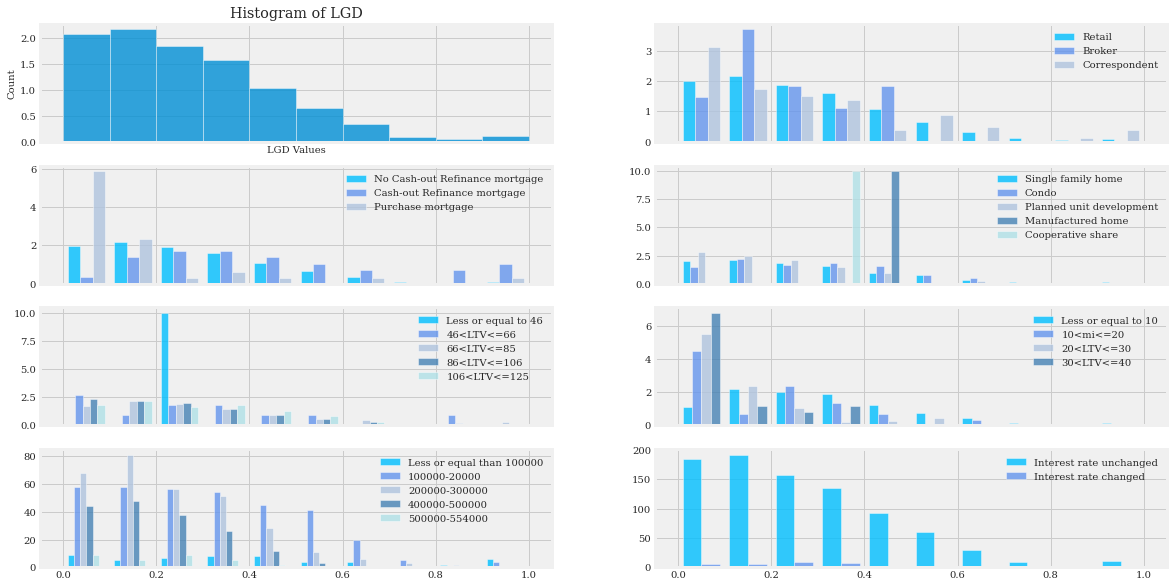

In [48]:
import seaborn as sns
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(18, 10))
# n, bins, _ = plt.hist(y, bins=10, density=True, alpha = 1, linewidth=0.5, edgecolor='white')
ax[0,0].hist(y, bins=10, density=True, alpha = 0.8, linewidth=0.5, edgecolor='white')
ax[0,0].set_title('Histogram of LGD')
ax[0,0].set_xlabel('LGD Values', {'fontsize':'medium'})
ax[0,0].set_ylabel('Count', {'fontsize':'medium'})


my_cmap = sns.light_palette("Navy", as_cmap=True)
colors = np.linspace(0,1,3)
ax[0,1].hist(all_lgd, bins, density=True,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue'], edgecolor='white', alpha = 0.8, label= ['Retail', 'Broker', 'Correspondent']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[0,1].legend()

ax[1,0].hist(all_lgd_purpose, bins, density=True,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue'], edgecolor='white', alpha = 0.8, label= ['No Cash-out Refinance mortgage', 'Cash-out Refinance mortgage', 'Purchase mortgage']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[1,0].legend()

ax[1,1].hist(all_lgd_PROP_TYPE, bins, density=True,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Single family home', 'Condo', 'Planned unit development', 'Manufactured home', 'Cooperative share']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[1,1].legend()

ax[2,0].hist(all_lgd_LTV, bins, density=True,color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 46', '46<LTV<=66', '66<LTV<=85', '86<LTV<=106', '106<LTV<=125']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[2,0].legend()

ax[2,1].hist(all_lgd_mi_pct,density=True, color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue'], edgecolor='white', alpha = 0.8, label= ['Less or equal to 10', '10<mi<=20', '20<LTV<=30', '30<LTV<=40']) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[2,1].legend()

ax[3,1].hist(all_lgd_interest_rate,density=False, color = ['deepskyblue', 'cornflowerblue'], edgecolor='white', alpha = 0.8, label= ['Interest rate unchanged', 'Interest rate changed' ]) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[3,1].legend()

ax[3,0].hist(all_lgd_orig_upb,density=False, color = ['deepskyblue', 'cornflowerblue', 'lightsteelblue', 'steelblue', 'powderblue', 'aqua'], edgecolor='white', alpha = 0.8, label= ['Less or equal than 100000', '100000-20000', '200000-300000', '400000-500000', '500000-554000' ]) #stacked by channel. If the density is set to True, then the area for each histogram is set so to be integrated to 1
ax[3,0].legend()


In [ ]:
#create extra column that would allow to do split in stratified fashion, bins are taken from the histogram

data['stratification'] = 0
for index in range(len(bins)):
    data['stratification'] = np.where(data.LGD > bins[index], bins[index], data.stratification)

In [51]:
# list(set(data.dtypes.tolist())) #checking the dtypes in dataframe
df_num = data.select_dtypes(include = ['float64', 'int64'])
df_num.head()


Period  delq_sts  loan_age  ...  orig_loan_term  cnt_borr    LGD
0  201907         0        99  ...             360         1  0.265
1  201306        16        28  ...             360         1  0.162
2  201305         2        27  ...             360         1  0.000
3  201208        10        18  ...             360         1  0.057
4  201207        10        17  ...             360         2  0.049

[5 rows x 49 columns]

In [ ]:
# Building histograms with seaborn
import seaborn as sns
# g = sns.FacetGrid(df_num, col="fico", col_wrap=4, height=2, ylim=(0, 10))
clear_output()

Note: exclude variables with only one value: period_diff,  CD_Zero_Bal,


In [ ]:
df_num_corr = df_num.corr(method ='spearman')['LGD'][:-1] # 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.2].sort_values(ascending=False)
print("There is {} strongly correlated values with LGD:\n{}".format(len(golden_features_list), golden_features_list))

There is 18 strongly correlated values with LGD:
LGD                      1.000000
prior_delq_sts_2         0.298604
days_dlq                 0.298323
prior_delq_sts           0.298147
delq_sts_new             0.293376
delq_sts                 0.293376
misc_costs              -0.203751
maint_pres_costs        -0.230165
collateral_Deficiency   -0.259018
legal_costs             -0.263596
default_upb             -0.283854
prior_upb               -0.283854
zb_removal_upb          -0.283854
orig_upb                -0.292703
MI_Recoveries           -0.415544
mi_pct                  -0.419982
Net_Sale_Proceeds       -0.514130
actual_loss             -0.827012
Name: LGD, dtype: float64


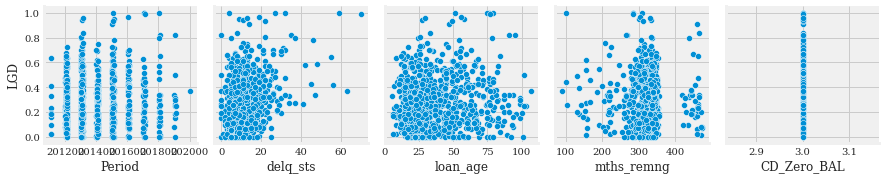

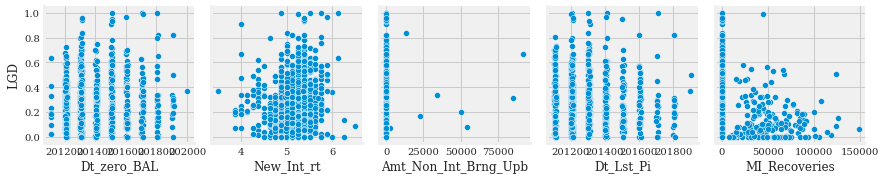

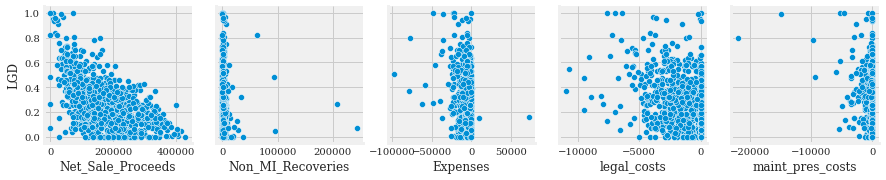

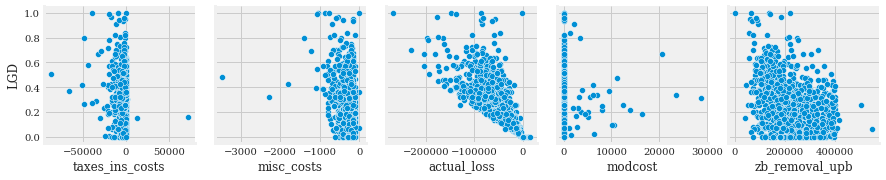

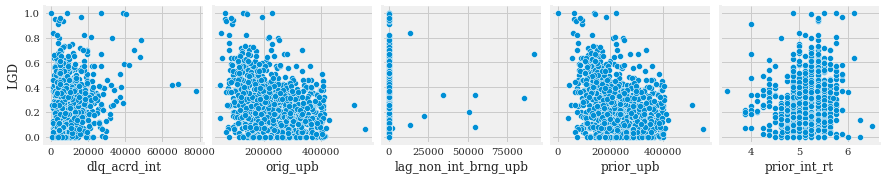

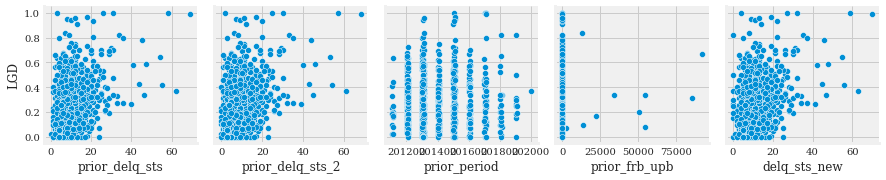

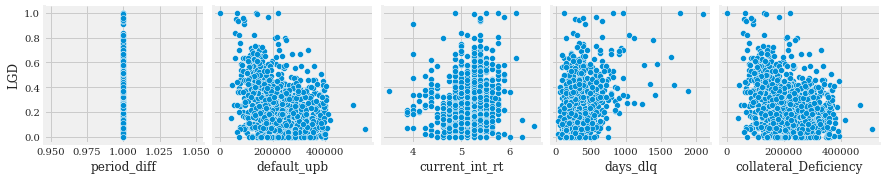

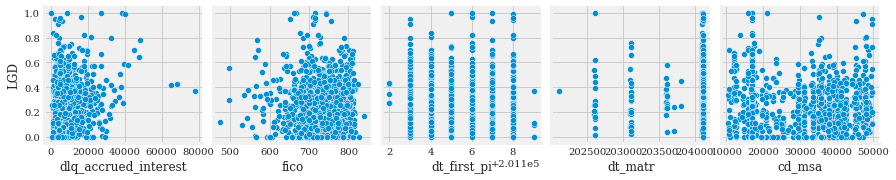

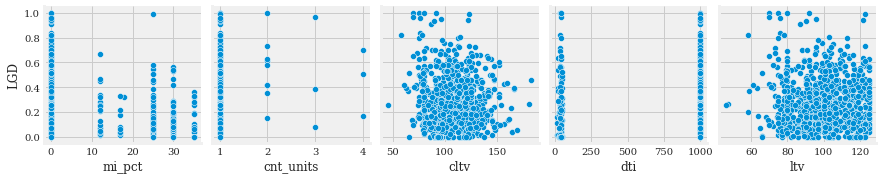

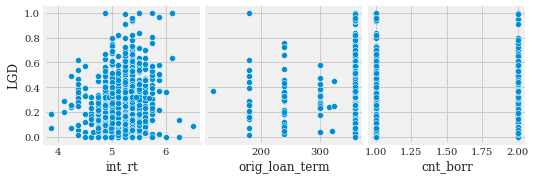

In [ ]:
import seaborn as sns
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num.drop(['stratification'], axis=1),
                x_vars=df_num.drop(['LGD','stratification'], axis=1).columns[i:i+5],
                y_vars=['LGD'])

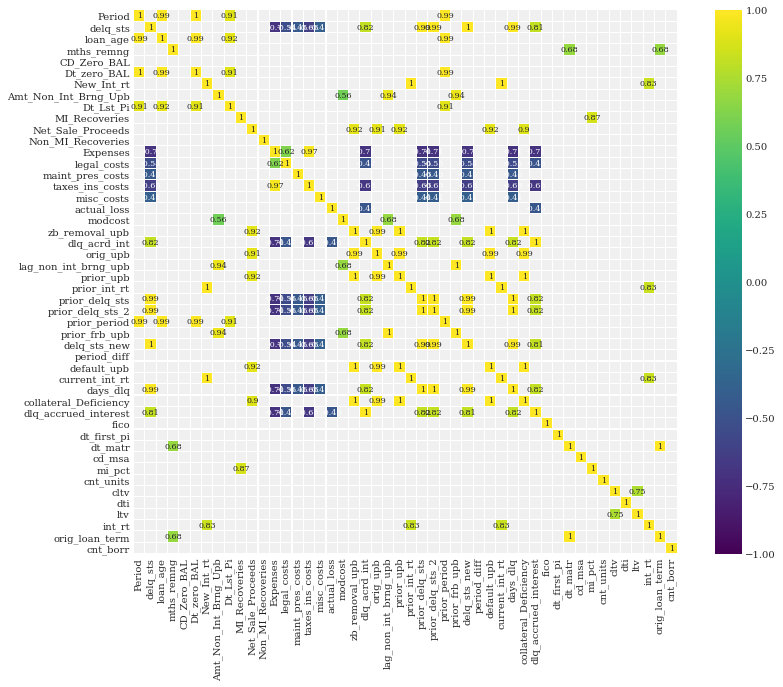

In [ ]:
corr = df_num.drop(['LGD', 'stratification'], axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Gradient Boosting Regressor
The regressor uses RMSE as a loss function. This is the baseline model set to test the performance of the methods in question. The gridsearch of the hyperparameters has not been performed yet. 

The date-time variables have been dropped for now, yet they are to be considered in the future.

In [ ]:
# [print(element) for element in enumerate(data.columns)]
clear_output()

In [ ]:
#create extra column that would allow to do split in stratified fashion, bins are taken from the histogram

data['stratification'] = 0
for index in range(len(bins)):
    data['stratification'] = np.where(data.LGD > bins[index], bins[index], data.stratification)

In [ ]:
#Quick model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds'], axis=1)
y = data['LGD']
# # stratified fashion
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0, stratify = data['stratification'] )
# X_train1, X_val, y_train1, y_val  = train_test_split(X_train1, y_train1, test_size=0.25, random_state=1, stratify = X_train1['stratification'] ) # 0.25 x 0.8 = 0.2
# # dropping the columns of 'stratification'
# X_train1 = X_train1.drop(columns = ['stratification'], axis=1)
# X_test1 = X_test1.drop(columns = ['stratification'], axis=1)
# X_val = X_val.drop(columns = ['stratification'], axis=1)

# # not stratified fashion
# # X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0)
# # categorical features of the model
# cat_features = ['loan_purpose', 'prop_type', 'st', 'prod_type', 'ppmt_pnlty', 'channel', 'occpy_sts', 'occpy_sts', 'flag_fthb',
#                'CD_Zero_BAL']
# # Creating Pool
# train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
# test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)
# eval_dataset = Pool(data = X_val, label=y_val, cat_features = cat_features )


# # params metadata
# param = {'bagging_temperature': 0,
#  'bootstrap_type': 'Bayesian',
#  'depth': 2,
#  'l2_leaf_reg': 7,
#  'learning_rate': 0.02,
#  'max_leaves': 3,
#  'score_function': 'NewtonL2'}
# #delq_string should be tranformed to list, month_string should be transformed to list of dates 
# model = CatBoostRegressor(iterations=2000,
#                           # custom_loss=[metrics.RMSE()],
#                           eval_metric = 'R2',
                          
#                           learning_rate=0.02,
#                           # eval_metric='R2',
#                           use_best_model = True, 
#                           early_stopping_rounds = 200,
#                           bootstrap_type = 'Bayesian',
#                           bagging_temperature = 0,
#                                 # save_snapshot=True,
#                                 # snapshot_interval=1600, 
#                                 # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/snapshots.cbsnapshot',
#                           grow_policy = 'SymmetricTree', 
#                           ignored_features = [20, 51, 8, 37,6, 30, 27, 13, 14, 15, 16, 17, 53, 52], #does not exclude 8, 20, 51, 37, 6
#                           # max_leaves = 3,
#                           leaf_estimation_method = 'Newton',
#                           leaf_estimation_backtracking = 'AnyImprovement',
#                           boosting_type = 'Plain',
#                           logging_level='Silent',
#                           task_type = 'CPU',
#                           score_function = 'L2',
#                           depth=2,
#                           l2_leaf_reg= 7,
#                           train_dir= '/content/drive/My Drive/Model results/model_results_09_08_00'),
#                           # quantization parameters
#                           border_count = 300,
#                           feature_border_type = 'MinEntropy', 
#                           one_hot_max_size=10
#                           # monotonicity constraints
#                           # monotone_constraints = {'44':-1, '28':1, '23':-1}
#                           )


# # Fit model
# model.fit(train_dataset, eval_set = eval_dataset, plot=True)
# # Get predictions
# preds = model.predict(test_dataset)

In [ ]:
X

Period  delq_sts  loan_age  ...  loan_purpose  orig_loan_term  cnt_borr
0     201907         0        99  ...             C             360         1
1     201306        16        28  ...             N             360         1
2     201305         2        27  ...             N             360         1
3     201208        10        18  ...             N             360         1
4     201207        10        17  ...             N             360         2
5     201403        12        37  ...             C             360         1
6     201410         4        43  ...             C             360         2
7     201306         4        28  ...             N             360         2
8     201405        28        39  ...             P             360         1
9     201607        15        65  ...             C             360         1
10    201503        24        49  ...             C             360         1
12    201110         6         8  ...             P             360         1
13    201510        19        56  ...             P             360         1
14    201209        10        19  ...             P             360         2
16    201304        11        26  ...             N             360         1
20    201303         6        25  ...             N             360         2
21    201605        10        63  ...             N             360         2
22    201311        14        33  ...             P             360         2
23    201304         9        26  ...             N             360         1
24    201409         4        43  ...             N             360         1
25    201203         6        12  ...             N             360         2
26    201503         8        49  ...             N             360         2
27    201409        24        42  ...             P             360         1
28    201206         6        16  ...             C             360         1
29    201305         7        26  ...             P             360         2
30    201905         0        99  ...             P             360         1
31    201303        16        24  ...             N             360         2
32    201610        25        68  ...             C             360         1
34    201312         9        33  ...             N             360         1
35    201612         7        68  ...             P             360         1
36    201407        12        40  ...             C             360         1
37    201507        27        51  ...             P             360         1
38    201212         6        21  ...             C             360         2
39    201701         7        70  ...             P             360         1
43    201506        15        50  ...             P             360         1
44    201512        31        56  ...             N             360         1
45    201305         7        25  ...             P             360         1
46    201704         9        72  ...             C             360         1
49    201411         6        43  ...             N             360         2
50    201211        12        19  ...             C             360         1
51    201504        13        49  ...             N             360         1
52    201112         4         8  ...             C             360         1
53    201312        11        32  ...             N             360         2
54    201610         7        66  ...             N             360         1
55    201205         7        13  ...             P             360         1
56    201306        14        26  ...             P             360         1
57    201411        15        43  ...             C             360         1
60    201508         8        52  ...             C             360         1
61    201505        14        51  ...             P             360         1
62    201409        22        43  ...             C             180         2
63    201303         8      

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# adjusted R^2 function

# def adj_r2(y_test1, preds):
#     return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))

def adj_r2(X_actual_test, y_actual_test, predictions):
    return 1-(1-r2_score(y_actual_test, predictions))*((len(X_actual_test)-1)/(len(X_actual_test)-len(X_actual_test.columns)-1))

#Training  results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, model.predict(train_dataset)))

Training: Adjusted R^2 0.6025905861768563
Training: R^2 of the model 0.646933110245544
Training: RMSE of the model 0.11795445286511673
Training: MSE of the model 0.013913252950709044


In [ ]:
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.42314289589394793
Testing: R^2 of the model 0.5355451992675536
Testing: RMSE of the model 0.13282036483430132
Testing: MSE of the model 0.017641249314716903


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 0 to 1055
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID_loan                908 non-null    object        
 1   Period                 908 non-null    int64         
 2   delq_sts               908 non-null    int64         
 3   loan_age               908 non-null    int64         
 4   mths_remng             908 non-null    int64         
 5   repch_flag             908 non-null    object        
 6   CD_Zero_BAL            908 non-null    int64         
 7   Dt_zero_BAL            908 non-null    int64         
 8   New_Int_rt             908 non-null    float64       
 9   Amt_Non_Int_Brng_Upb   908 non-null    float64       
 10  Dt_Lst_Pi              908 non-null    float64       
 11  MI_Recoveries          908 non-null    float64       
 12  Net_Sale_Proceeds      908 non-null    float64       
 13  Non_

In [ ]:
# Saving model to JSON files
import datetime
# pool = Pool(
#     data=X.drop(columns = ['stratification'], axis=1),
#     label=y,
#     cat_features=cat_features,
#     # feature_names=list(X.columns), 
# )


model.save_model(
    '/content/drive/My Drive/Model results/model_results_04_08_06/model-trained-on-{file_name}.json'.format(file_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

In [ ]:
print(model.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'RMSE', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 15000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'counter_calc_method': 'SkipTest', 'grow_policy': 'Lossguide', 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'pinned_memory_bytes': '104857600', 'l2_leaf_reg': 5, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': True, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorder

In [ ]:
# cross-validation 
from catboost import cv
params = {"iterations": 10000,
          "depth": 5,
          'learning_rate':0.02,
          'task_type' : 'GPU',
          "loss_function": "RMSE",
          "verbose": False}

scores = cv(train_dataset,
            params,
            fold_count=5, 
            plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
data.info

<bound method DataFrame.info of            ID_loan  Period  delq_sts  ...  cnt_borr    LGD stratification
0     F111Q1001064  201907         0  ...         1  0.265            0.2
1     F111Q1004260  201306        16  ...         1  0.162            0.1
2     F111Q1004580  201305         2  ...         1  0.000            0.0
3     F111Q1004663  201208        10  ...         1  0.057            0.0
4     F111Q1004665  201207        10  ...         2  0.049            0.0
...            ...     ...       ...  ...       ...    ...            ...
1050  F111Q2240130  201407        15  ...         1  0.074            0.0
1051  F111Q2244003  201906         0  ...         1  0.817            0.8
1052  F111Q2244349  201312        13  ...         1  0.957            0.9
1053  F111Q2245120  201512        42  ...         2  0.579            0.5
1055  F111Q2247366  201712        63  ...         2  0.370            0.3

[908 rows x 61 columns]>

### Model with GridSearch 

In contrast to grid search, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is specified in the n_iter parameter.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'stratification'], axis=1)
# y = data['LGD']
# stratified fashion
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=0, stratify = data['stratification'] )

cat_features = ['loan_purpose', 'prop_type', 'st', 'prod_type', 'ppmt_pnlty', 'channel', 'occpy_sts', 'occpy_sts', 'flag_fthb',
               'CD_Zero_BAL']
# Creating Pool
train_dataset = Pool(data = X_train1, label=y_train1, cat_features=cat_features)
test_dataset = Pool(data = X_test1, label=y_test1, cat_features=cat_features)



grid = {'learning_rate': [0.01, 0.02, 0.1, 0.2],
        'depth': [2, 3, 4, 5, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9], 
        'bootstrap_type':['Bayesian'], 
        'bagging_temperature':[0], 
        # 'max_leaves': [3,5,7,10,15,20],
        'score_function':['NewtonL2', 'NewtonCosine'], 
        'early_stopping_rounds': [50,100, 200, 300, 400]
        }
        # 'boosting_type': 'Ordered', 
        # 'logging_level': 'Silent', 
        # 'task_type': 'GPU'}

hyper_model = CatBoostRegressor(boosting_type = 'Plain',
                                logging_level='Silent',
                                eval_metric='R2',
                                task_type = 'GPU', 
                                # early_stopping_rounds = 1000, 
                                grow_policy = 'Depthwise',
                                # use_best_model = True, 
                                leaf_estimation_method = 'Newton',
                                # use_best_model = True 
                                # iterations = 2000,
                                
                                train_dir= '/content/drive/My Drive/Model results/gridsearch_05_08_grid',
                                # snapshot_file = '/content/drive/My Drive/Model results/gridsearch_04_08_00/experiment.cbsnapshot'
                                )
randomized_search_result = hyper_model.grid_search(grid,
                                                         cv = 5,
                                                  # boosting_type = 'Ordered',
                                                  # logging_level='Silent',
                                                  # task_type = 'GPU',
                                                   plot=False,
                                                   X=train_dataset,
                                                   verbose = False
#                                                    y=y_train1,

                                                   )

# Fit model
hyper_model.fit(train_dataset, plot= False)
# Get predictions
preds = hyper_model.predict(test_dataset)

hyper_model.save_model(
    '/content/drive/My Drive/Model results/model_json/model-trained-on-{file_name}.json'.format(file_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric R2 is not implemented on GPU. Wil

NameError: ignored

In [ ]:
import datetime

hyper_model.save_model(
    '/content/drive/My Drive/Model results/model-trained-on-{file_name}.json'.format(file_name=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")), #path to the model with datetime
    format="json",
    pool=train_dataset  # training dataset that is previously used for training
)

In [ ]:
# tensorboard --logdir=<train_dir>
# print(hyper_model.get_params())
hyper_model.get_all_params()

{'add_ridge_penalty_to_loss_function': False,
 'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 128,
 'classes_count': 0,
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'counter_calc_method': 'SkipTest',
 'ctr_history_unit': 'Sample',
 'ctr_target_border_count': 1,
 'data_partition': 'DocParallel',
 'depth': 6,
 'devices': '-1',
 'eval_metric': 'R2',
 'feature_border_type': 'GreedyLogSum',
 'fold_permutation_block': 64,
 'fold_size_loss_normalization': False,
 'gpu_cat_features_storage': 'GpuRam',
 'gpu_ram_part': 0.95,
 'grow_policy': 'Lossguide',
 'has_time': False,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtrac

In [ ]:
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, hyper_model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, hyper_model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, hyper_model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, hyper_model.predict(train_dataset)))

Training: Adjusted R^2 0.9942870640809528
Training: R^2 of the model 0.9947646438975293
Training: RMSE of the model 0.014312804088531542
Training: MSE of the model 0.0002048563608766852


In [ ]:
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)

print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.40247382499945117
Testing: R^2 of the model 0.5189035576282346
Testing: RMSE of the model 0.13517893277673484
Testing: MSE of the model 0.018273343866657


In [ ]:
randomized_search_result['params']

{'bagging_temperature': 0,
 'bootstrap_type': 'Bayesian',
 'depth': 2,
 'l2_leaf_reg': 1,
 'learning_rate': 0.1,
 'od_wait': 50,
 'score_function': 'NewtonCosine'}

### Reporting results: metrics

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [ ]:
# adjusted R^2 function

# def adj_r2(y_test1, preds):
#     return 1-(1-r2_score(y_test1, preds))*((len(X_test1)-1)/(len(X_test1)-len(X_test1.columns)-1))

def adj_r2(X_actual_test, y_actual_test, predictions):
    return 1-(1-r2_score(y_actual_test, predictions))*((len(X_actual_test)-1)/(len(X_actual_test)-len(X_actual_test.columns)-1))

In [ ]:
#Training  results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, model.predict(train_dataset)))
print('Training: R^2 of the model', r2_score(y_train1, model.predict(train_dataset)))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, model.predict(train_dataset)))))
print('Training: MSE of the model', mean_squared_error(y_train1, model.predict(train_dataset)))

Training: Adjusted R^2 0.6855551892846645
Training: R^2 of the model 0.7118415851331075
Training: RMSE of the model 0.10618600123583243
Training: MSE of the model 0.011275466858456205


In [ ]:
#Testing results without any hyper search with RMSE as the loss function
#Huber loss with delta = 0.1, learning rate = 0.02, iterations = 20000, Cosine score function
rmse = (np.sqrt(mean_squared_error(y_test1, preds)))
r2 = r2_score(y_test1, preds)
print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, preds))
print('Testing: R^2 of the model', r2)
print('Testing: RMSE of the model', rmse)
print('Testing: MSE of the model', mean_squared_error(y_test1, preds))

Testing: Adjusted R^2 0.27290071233957924
Testing: R^2 of the model 0.4145781470675288
Testing: RMSE of the model 0.14911708512936128
Testing: MSE of the model 0.02223590507747718


#### Model Benchmarking with OLS

In [ ]:
import statsmodels.api as sm
benchmarking_X = data.drop(columns = ['LGD', 'repch_flag', 'ID_loan', 'actual_loss', 'MI_Recoveries', 'default_upb', 'Net_Sale_Proceeds', 'flag_fthb', 'channel', 'ppmt_pnlty', 'prod_type', 'st', 'prop_type', 'loan_purpose', 'occpy_sts', 'collateral_Deficiency', 'delq_string', 'orign_qtr', 'stratification', 'Non_MI_Recoveries', 'Expenses', 'legal_costs', 'maint_pres_costs', 'legal_costs', 'CD_Zero_BAL'], axis=1)
benchmarking_y = data['LGD']
X_train1, X_test1, y_train1, y_test1 = train_test_split(benchmarking_X, benchmarking_y, test_size=0.2, random_state=0)


In [ ]:
benchmarking_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 0 to 1055
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Period                908 non-null    int64  
 1   delq_sts              908 non-null    int64  
 2   loan_age              908 non-null    int64  
 3   mths_remng            908 non-null    int64  
 4   Dt_zero_BAL           908 non-null    int64  
 5   New_Int_rt            908 non-null    float64
 6   Amt_Non_Int_Brng_Upb  908 non-null    float64
 7   Dt_Lst_Pi             908 non-null    float64
 8   taxes_ins_costs       908 non-null    float64
 9   misc_costs            908 non-null    float64
 10  modcost               908 non-null    float64
 11  zb_removal_upb        908 non-null    float64
 12  dlq_acrd_int          908 non-null    float64
 13  orig_upb              908 non-null    int64  
 14  lag_non_int_brng_upb  908 non-null    float64
 15  prior_upb             

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_predicted = lm.predict(X_test1)
y_train_predict = lm.predict(X_train1)


print('Testing: Adjusted R^2', adj_r2(X_test1, y_test1, y_predicted))
print('Testing: R^2 of the model', r2_score(y_test1, y_predicted))
print('Testing: RMSE of the model', (np.sqrt(mean_squared_error(y_test1, y_predicted))))
print('Testing: MSE of the model', mean_squared_error(y_test1, y_predicted))

print('Training: Adjusted R^2', adj_r2(X_train1, y_train1, y_train_predict))
print('Training: R^2 of the model', r2_score(y_train1, y_train_predict))
print('Training: RMSE of the model', (np.sqrt(mean_squared_error(y_train1, y_train_predict))))
print('Training: MSE of the model', mean_squared_error(y_train1, y_train_predict))

Testing: Adjusted R^2 0.26240457611862344
Testing: R^2 of the model 0.4172588640053213
Testing: RMSE of the model 0.1475853982941643
Testing: MSE of the model 0.02178144978964712
Training: Adjusted R^2 0.4273110032038089
Training: R^2 of the model 0.4573278057945058
Training: RMSE of the model 0.14572585580915462
Training: MSE of the model 0.021236025051310524


#### Results of the model

The results of the model suggests that the model explains most of the variance in the data, judging by the adjusted R^2, R^2 and RMSE. 

### Feature Importance

This section considers two distinct methods in calculating feature importance. 

* **Shap Values**: A vector $\nu$  with contributions of each feature to the prediction for every input object and the expected value of the model prediction for the object (average prediction given no knowledge about the object).
* **PredictionValuesChange**: For each feature, PredictionValuesChange shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
* **LossFunctionChange**: The individual importance values for each of the input features (the default feature importances calculation method for ranking metrics). This type of feature importance can be used for any model, but is particularly useful for ranking models, where other feature importance types might give misleading results. For each feature the value represents the difference between the loss value of the model with this feature and without it. *Since it is computationally expensive to retrain the model without one of the features, this model is built approximately using the original model with this feature removed from all the trees in the ensemble.*

Last two are calculated for training and testing sets. Both are of great importance since: 
1. The use of training set allows to assess how much the model relies on each feature for making predictions
2. The use of testing set allows to evaluate how much the feature contributes to the performance of the model on unseen data 

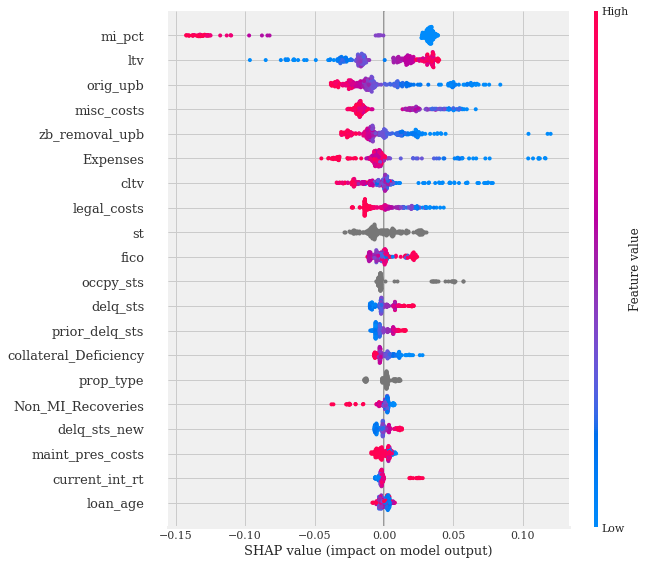

In [ ]:
# Starting with Shap Values. Calculating each single contribution
import shap
shap_values = model.get_feature_importance(test_dataset, type="ShapValues")

shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X_test1) 

In [ ]:
# matplotlib settings
import matplotlib as mpl
plt.style.use(['seaborn-bright'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})

%matplotlib inline

In [ ]:

from sklearn import metrics


def get_feature_imp_plot(method):
    
#     if method == "Permutation":
#         fi =  permutation_importances(model, X_test1, y_test1, log_loss)
    
#     elif method == "Baseline":
#         fi = baseline_importance(model, X_train1, y_train1, X_test1, y_test1, log_loss)
    
#     elif method == "ShapeValues":
#         shap_values = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
#                                                                      type="ShapValues")
#         shap_values = shap_values[:,:-1]
#         shap.summary_plot(shap_values, X_test) 
        
#     else:
    fi = model.get_feature_importance(Pool(X_test1, label=y_test1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_test1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Testing set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

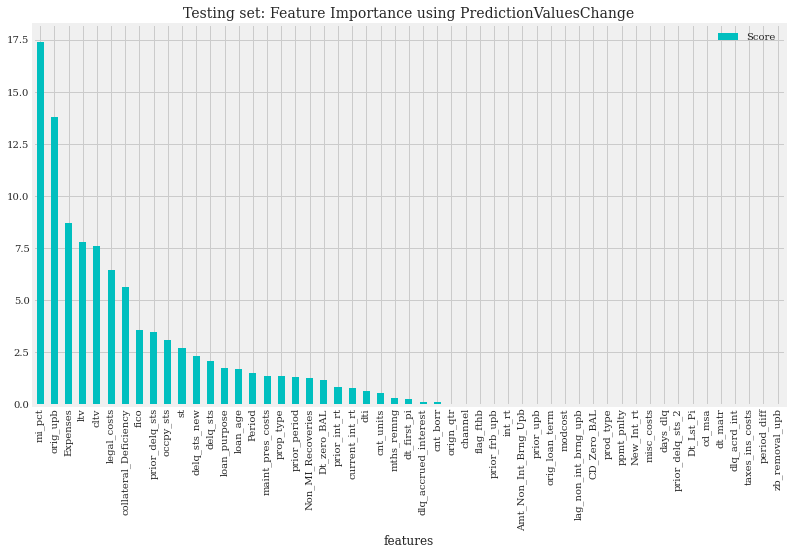

In [ ]:
get_feature_imp_plot(method="PredictionValuesChange")

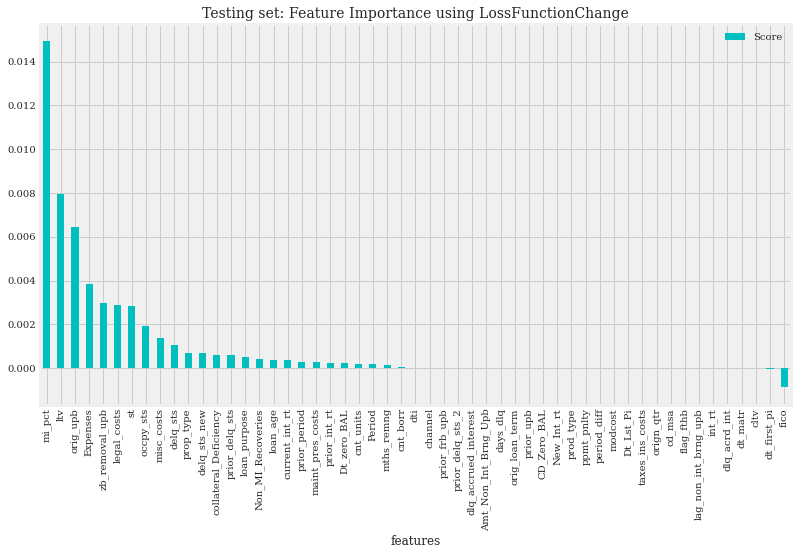

In [ ]:
get_feature_imp_plot(method="LossFunctionChange")

In [ ]:
def get_feature_imp_plot_train(method):
    

    fi = model.get_feature_importance(Pool(X_train1, label=y_train1,cat_features=cat_features), 
                                                                     type=method)
        
    if method != "ShapeValues":
        feature_score = pd.DataFrame(list(zip(X_train1.dtypes.index, fi )),
                                        columns=['Feature','Score'])

        feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

        plt.rcParams["figure.figsize"] = (12,7)
        ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
        ax.set_title("Training set: Feature Importance using {}".format(method), fontsize = 14)
        ax.set_xlabel("features")
        plt.show()

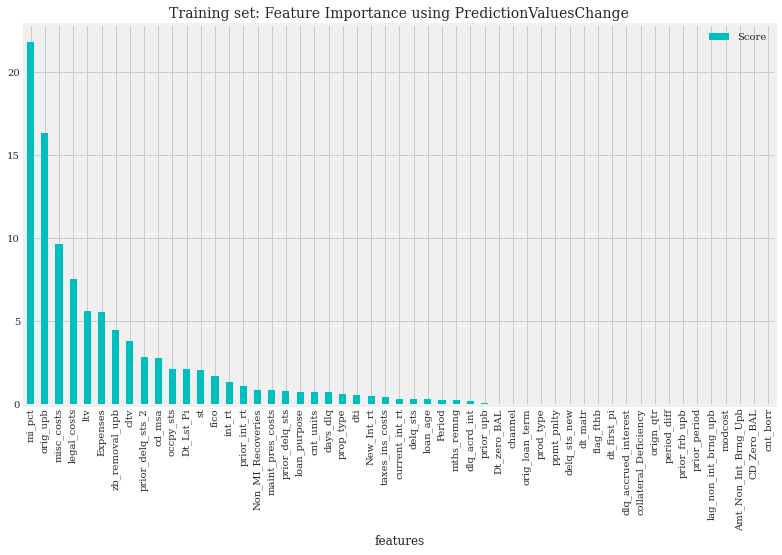

In [ ]:
get_feature_imp_plot_train(method="PredictionValuesChange")

In [ ]:
get_feature_imp_plot_train(method="LossFunctionChange")

NameError: name 'get_feature_imp_plot_train' is not defined

In [ ]:
# Check the error distribution and then minimise the Huber function

# model_huber = CatBoostRegressor(iterations=1000,
#                           learning_rate=1,
#                           logging_level='Silent',
#                           loss_function='Huber',
#                           depth=2)


# # Fit model
# model_huber.fit(train_dataset, plot=True)
# # Get predictions
# preds_huber = model.predict(test_dataset)
clear_output()